# **Introduction to Adaptive Filtering**

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from motion_blur import motion_blur

Get Images

In [2]:
image = cv2.cvtColor(cv2.imread('sign.jpg'), cv2.COLOR_BGR2RGB)
image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32FC1)

In [128]:
# generate correlated noise
sig = 0.075 # noise power
corr_noise = np.random.normal(0, sig, size=image.shape) * np.sqrt(image)
corr_noise += np.random.normal(0, sig, size=image.shape)

kernel = np.ones((3,3))/9
corr_noise = cv2.filter2D(corr_noise, ddepth=-1, kernel=kernel)

# add to image
noisy_image = image + corr_noise

# or use iid noise
# noisy_image = image + np.random.normal(0, sig, size=image.shape)
noisy_image = cv2.normalize(noisy_image, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32FC1)


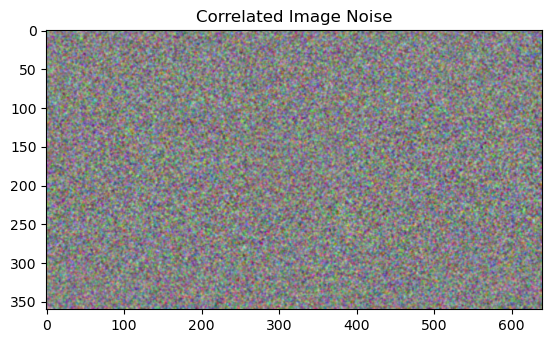

Compute Noise Power Spectrum

In [433]:
noise_auto_corr = cv2.filter2D(corr_noise, ddepth=-1, kernel=corr_noise)
# N = np.fft.fftshift(np.fft.fft2(corr_noise), axes=(1))
N = np.fft.fftshift(np.fft.fft2(noise_auto_corr), axes=(1))

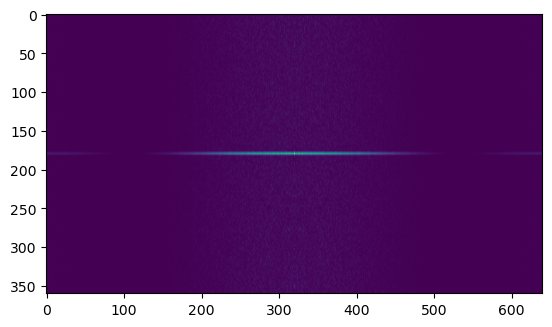

In [440]:
plt.imshow(np.abs(N)[:, :, 0])

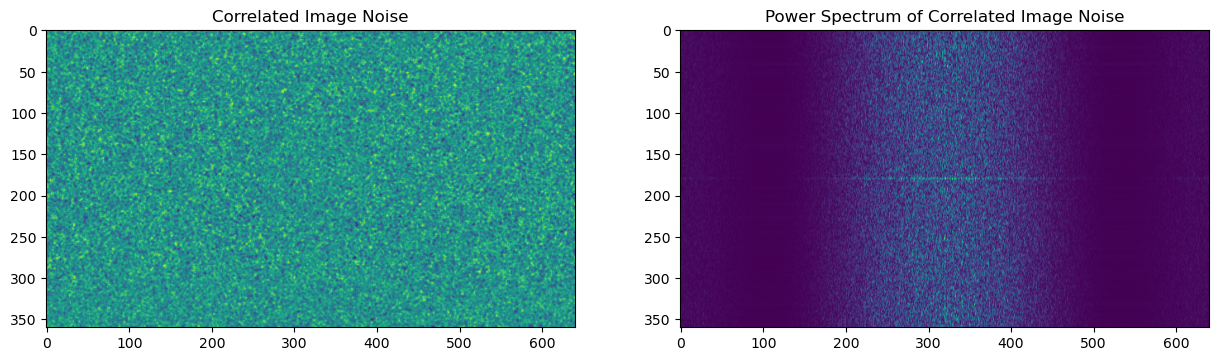

In [448]:
_axis = 2
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(cv2.normalize(corr_noise, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32FC1)[:, :, _axis])
ax[0].set_title("Correlated Image Noise");
ax[1].imshow(np.abs(N)[:, :, _axis])
ax[1].set_title("Power Spectrum of Correlated Image Noise");

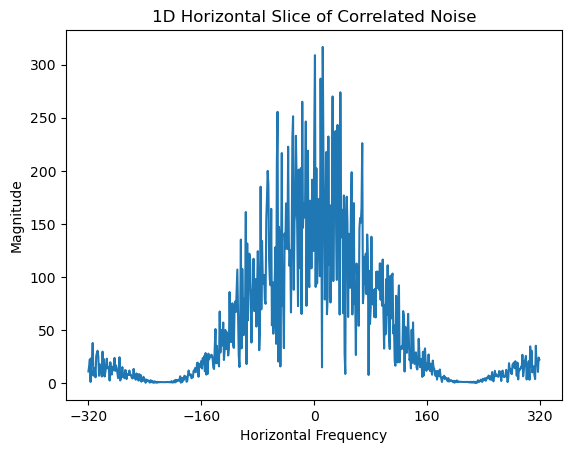

In [447]:
plt.plot(np.arange(-320, 320), np.abs(N)[180, :, 2])
plt.title("1D Horizontal Slice of Correlated Noise")
plt.xticks([-320, -160, 0, 160, 320])
plt.xlabel("Horizontal Frequency")
plt.ylabel("Magnitude");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


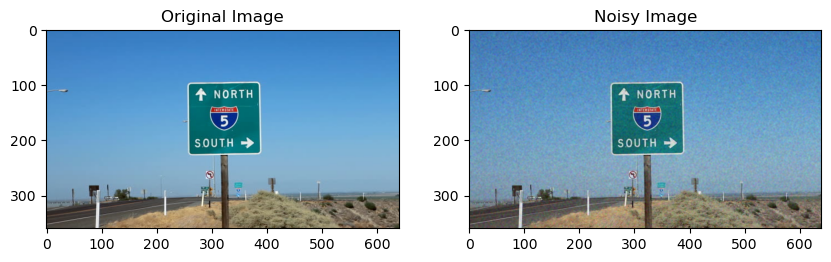

In [130]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(noisy_image)
ax[1].set_title("Noisy Image");

In [131]:
# compute local mean
mu = cv2.boxFilter(noisy_image, ddepth=-1, ksize=(7,7))

In [132]:
# compute local standard deviation
sigma = np.sqrt((cv2.boxFilter(noisy_image**2, ddepth=-1, ksize=(7,7)) 
                 - (mu**2)))

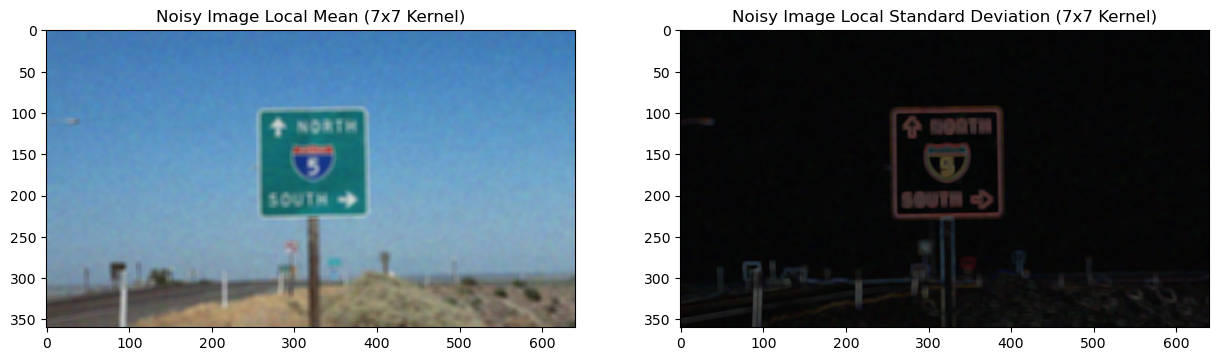

In [133]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mu)
ax[0].set_title("Noisy Image Local Mean (7x7 Kernel)")
ax[1].imshow(sigma)
ax[1].set_title("Noisy Image Local Standard Deviation (7x7 Kernel)");

## Adaptive Mean Filter

$$
\begin{align*}
    \hat{f}(x,y) - &\text{ Estimated image }
    \\
    g(x,y) - &\text{ Original image with noise }
    \\
    \sigma_\eta^2 - &\text{ Estiamted Noise variance }
    \\
    S_{x,y} - &\text{ Local window centered around } (x,y)
    \\
    \sigma_{S_{x,y}}^2 - &\text{ Local Noise variance in } S_{x,y}
    \\
    \bar{z}_{S{x,y}} - &\text{ Local Mean in } S_{x,y}
    \\
    \\
    \\
    \\
    \hat{f}(x,y) &= g(x,y) - \frac{\sigma_\eta^2}{\sigma_{S_{x,y}}^2} \left[ g(x,y) - \bar{z}_{S{x,y}} \right]
\end{align*}
$$


We clip the ratio $\frac{\sigma_\eta^2}{\sigma_{S_{x,y}}^2}$ to $[0,1]$ to prevent nonsensical values from occuring

In [449]:
sigma_noise = 0.075 # "estimated" noise power

Implement Filter

In [450]:
filtered = noisy_image - np.clip(sigma_noise/sigma, 0, 1)*(noisy_image - mu)

OPTIONAL: Sharpen to reduce blurring

In [451]:
kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])
filtered = cv2.filter2D(filtered, -1, kernel)
filtered = cv2.convertScaleAbs(filtered, None, 255, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


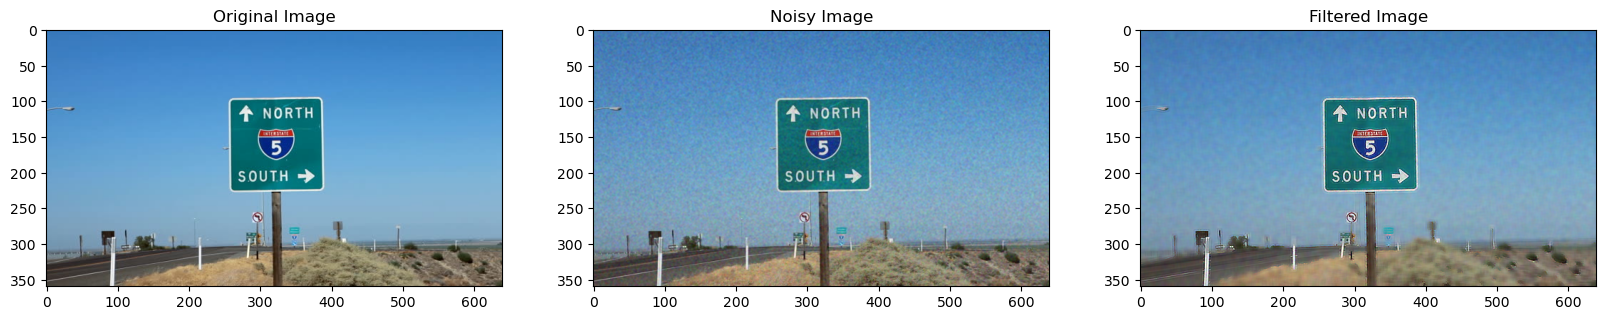

In [452]:
_, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(noisy_image)
ax[1].set_title("Noisy Image");
ax[2].imshow(filtered)
ax[2].set_title("Filtered Image");

Compare to Median Blur Results

In [552]:
med = cv2.medianBlur(cv2.normalize(noisy_image, None, 0, 256, cv2.NORM_MINMAX, cv2.CV_8UC3), ksize=3)

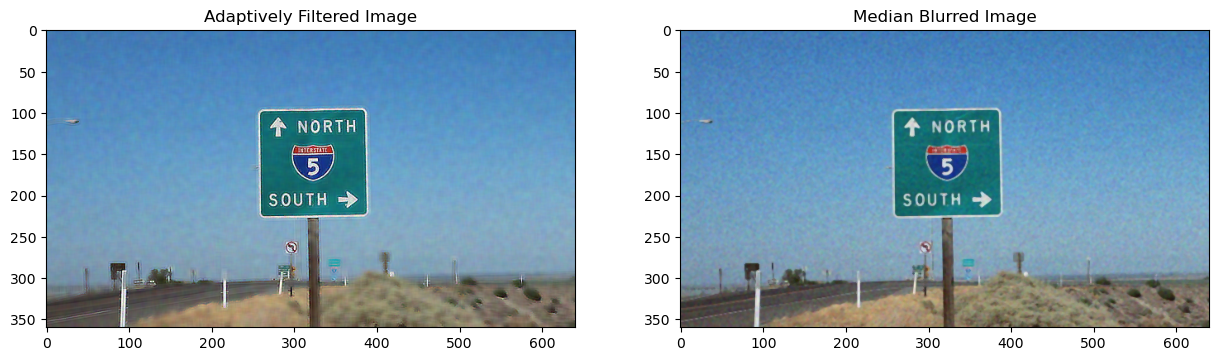

In [553]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(filtered)
ax[0].set_title("Adaptively Filtered Image")
ax[1].imshow(med)
ax[1].set_title("Median Blurred Image");

In [554]:
np.sum(np.square(image - filtered/255)), np.sum(np.square(image - med/med.max()))

(1624.630487616675, 1258.2667621183573)

In [456]:
image.min(), image.max()

(0.0, 1.0)

In [457]:
filtered.min(), filtered.max()

(0, 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


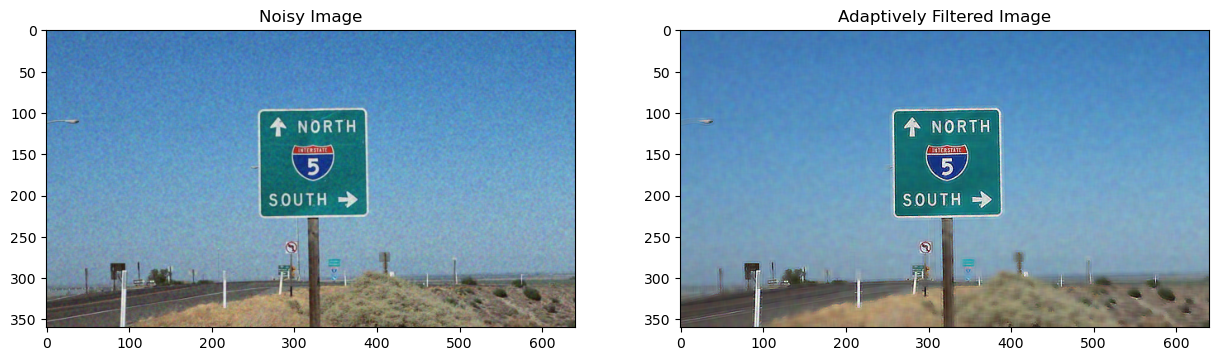

In [458]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(noisy_image)
ax[0].set_title("Noisy Image")
ax[1].imshow(filtered)
ax[1].set_title("Adaptively Filtered Image");

## Lee's Filter

ref: https://course.ccs.neu.edu/com3371/week7/westinAdaptiveFiltering.pdf

$$
\begin{align*}
    \hat{f}(x,y) - &\text{ Estimated image }
    \\
    g(x,y) - &\text{ Original image with noise }
    \\
    \sigma_\eta^2 - &\text{ Estiamted Noise variance }
    \\
    S_{x,y} - &\text{ Local window centered around } (x,y)
    \\
    \sigma_{S_{x,y}}^2 - &\text{ Local Noise variance in } S_{x,y}
    \\
    \bar{z}_{S{x,y}} - &\text{ Local Mean in } S_{x,y}
    \\
    \\
    \\
    \\
    \hat{f}(x,y) &= \bar{z}_{S{x,y}} - \frac{\sigma_{S_{x,y}}^2}{\sigma_{S_{x,y}}^2 + \sigma_\eta^2} \left[ g(x,y) - \bar{z}_{S{x,y}} \right]
\end{align*}
$$


In [585]:
# compute local mean
mu = cv2.boxFilter(noisy_image, ddepth=-1, ksize=(7,7))

In [586]:
# compute local standard deviation
sigma = np.sqrt((cv2.boxFilter(noisy_image**2, ddepth=-1, ksize=(7,7)) 
                 - (mu**2)))

In [587]:
tmp = cv2.normalize(corr_noise, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32FC1)

In [588]:
f_hat = (mu) - (sigma/(sigma + 100*tmp))*(noisy_image - (mu))

In [605]:
num = sigma - 100.05
num[num < 0] = 0

In [606]:
den = sigma.copy()
den[sigma < 100.05] = corr_noise[sigma < 100.05]


In [607]:
f_hat = (mu) - (num/den)*(noisy_image - (mu))

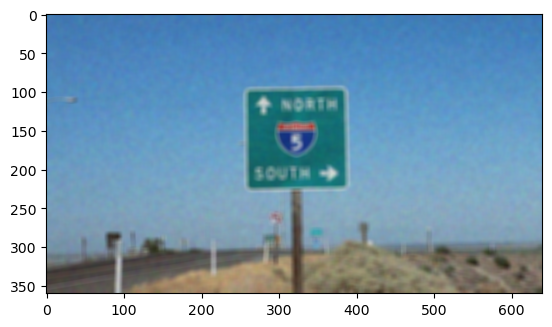

In [608]:
plt.imshow(f_hat)

In [609]:
np.sum(np.square(image - noisy_image)), np.sum(np.square(image - filtered/255)), np.sum(np.square(image - med/med.max())), np.sum(np.square(image - f_hat))

(1395.623, 1624.630487616675, 1258.2667621183573, 2813.4143)

## **Weiner Filter**

In [335]:
R = cv2.filter2D(noisy_image, ddepth=-1, kernel=noisy_image) # autocorrelation of noisy image
S = np.fft.fftshift(np.fft.fft2(R), axes=(1)) # Power Spectrum of Noisy Image

Point Spread Function

ref: https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/VELDHUIZEN/node10.html

In [344]:
n,m,_ = image.shape
u_index, v_index = np.meshgrid(np.arange(-(n//2), (n//2)), np.arange(-(m//2), (m//2)))
u_index = u_index.reshape((-1, 1))
v_index = v_index.reshape((-1, 1))

Compute Point Spred Function

In [355]:
def gaussian2(x, y, a=1, mu_x=0, mu_y=0, sig_x=1, sig_y=1):
    """ 2D Gaussian Window Function
        Inputs:
            x - horizontal location argument
            y - vertical location argument
            a - scalar amplitude 
            mu_x - x (horizontal) mean (controls horizontal center)
            mu_y - y (vertical) mean (controls vertical center)
            sig_x - x (horizontal) standard deviation (controls horizontal spread)
            sig_y - y (vertical) standard deviation (controls vertical spread)
        Outputs:
            output 2D Gaussian Function Response at x, y
        """
    return a*np.exp(- (((x - mu_x)**2)/(sig_x**2)) - (((y - mu_y)**2)/(sig_y**2)) )

In [420]:
h = gaussian2(u_index, v_index, sig_x=1, sig_y=1).reshape((m,n)).T
H = np.fft.fftshift(np.fft.fft2(h))

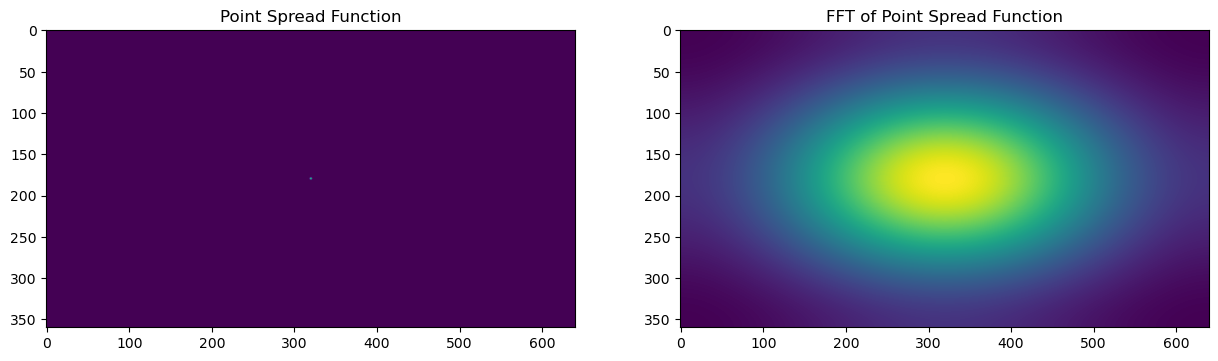

In [423]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(h)
ax[0].set_title("Point Spread Function")
ax[1].imshow(np.abs(H))
ax[1].set_title("FFT of Point Spread Function");

Construct Wiener Filter

In [430]:
H = H[:, :, None].repeat(3, axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


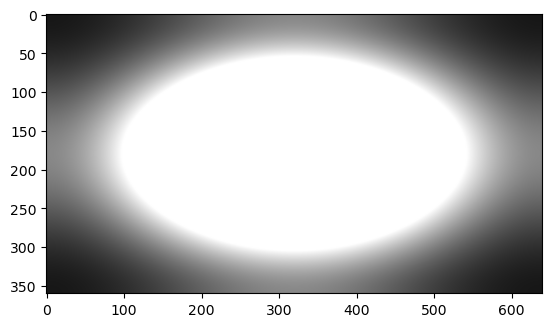

In [479]:
plt.imshow(np.abs(H))

In [472]:
W = (np.conjugate(H)*S)/((np.square(np.abs(H)) * S) + N)
W = (S)/(S + N)

In [473]:
G = np.fft.fftshift(np.fft.fft2(noisy_image), axes=(1)) # FFT of noisy image

Perform Wiener Filtering in Frequency Domain

In [474]:
F = G*W # Wiener Filtering in Frequency Domain

In [475]:
f = np.fft.ifft2(F) # IFFT of Wiener Filtered Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


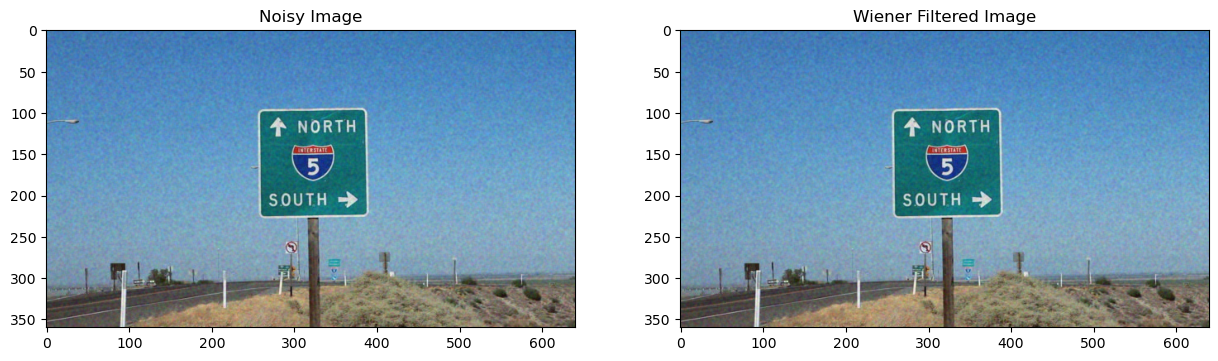

In [476]:
_, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(noisy_image)
ax[0].set_title("Noisy Image")
ax[1].imshow(np.abs(f))
ax[1].set_title("Wiener Filtered Image");

In [477]:
np.sum(np.square(image - noisy_image)), np.sum(np.square(image - np.abs(f)))

(1395.623, 1396.7634507271748)